In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Prepare

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [34]:
n_epochs = 10
batch_size = 4
lr = 0.001

In [7]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # standardize each color channel (3 channels)
    ]
)

In [9]:
train_dataset = torchvision.datasets.CIFAR10(
    root='../data', 
    train=True,
    download=True,
    transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='../data', 
    train=False,
    download=True,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100.0%


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [10]:
classes = (
    'plane',
    'car',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
)

# Check sizes

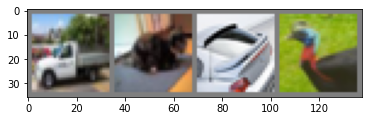

In [11]:
examples = iter(train_loader)
imgs, labels = examples.next()

def imshow(img):
    img = img / 2 + 0.5 # unnormalise
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

imshow(torchvision.utils.make_grid(imgs))

In [20]:
conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
pool = nn.MaxPool2d(kernel_size=2, stride=2)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

In [21]:
print(imgs.shape)

torch.Size([4, 3, 32, 32])


In [22]:
x = conv1(imgs)
print(x.shape)

torch.Size([4, 6, 28, 28])


In [23]:
x = pool(x)
print(x.shape)

torch.Size([4, 6, 14, 14])


In [24]:
x = conv2(x)
print(x.shape)

torch.Size([4, 16, 10, 10])


In [25]:
x = pool(x)
print(x.shape)

torch.Size([4, 16, 5, 5])


# Modelling

In [35]:
class Convet(nn.Module):
    def __init__(self, num_classes):
        super(Convet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5) # input channel size = last output channel size
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)
    
    def forward(self, X):
        out = self.pool(F.relu(self.conv1(X)))
        out = self.pool(F.relu(self.conv2(out)))
        out = out.view(-1, 16*5*5) # flatten tensor
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


model = Convet(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
n_total_steps = len(train_loader)

In [36]:
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        # original shape: [4, 3, 32, 32] = [4, 3, 1024] -> 3 color channels (32 * 32)
        # input_layer: 3 channels, 6 output channels, 5 kernel size
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print(f'epoch {epoch+1}/{n_epochs} step {i+1}/{n_total_steps}: Loss = {loss.item():.4f}')
print('Finish Training')

epoch 1/10 step 2000/12500: Loss = 2.3223
epoch 1/10 step 4000/12500: Loss = 2.2917
epoch 1/10 step 6000/12500: Loss = 2.2972
epoch 1/10 step 8000/12500: Loss = 2.3215
epoch 1/10 step 10000/12500: Loss = 2.2870
epoch 1/10 step 12000/12500: Loss = 2.3117
epoch 2/10 step 2000/12500: Loss = 2.2106
epoch 2/10 step 4000/12500: Loss = 2.2719
epoch 2/10 step 6000/12500: Loss = 1.6332
epoch 2/10 step 8000/12500: Loss = 1.4061
epoch 2/10 step 10000/12500: Loss = 1.8172
epoch 2/10 step 12000/12500: Loss = 1.4329
epoch 3/10 step 2000/12500: Loss = 2.0115
epoch 3/10 step 4000/12500: Loss = 1.1258
epoch 3/10 step 6000/12500: Loss = 0.9884
epoch 3/10 step 8000/12500: Loss = 1.4078
epoch 3/10 step 10000/12500: Loss = 1.8415
epoch 3/10 step 12000/12500: Loss = 2.9363
epoch 4/10 step 2000/12500: Loss = 1.2674
epoch 4/10 step 4000/12500: Loss = 1.1266
epoch 4/10 step 6000/12500: Loss = 1.8961
epoch 4/10 step 8000/12500: Loss = 1.1061
epoch 4/10 step 10000/12500: Loss = 1.9276
epoch 4/10 step 12000/12500

In [37]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(len(classes))]
    n_class_sample = [0 for i in range(len(classes))]
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predictions == labels).sum().item()

        for i in range(batch_size):
            lab = labels[i]
            pred = predictions[i]
            if (lab == pred):
                n_class_correct[lab] += 1
            n_class_sample[lab] += 1
    acc = n_correct / n_samples
    print(f'Overall Test Accuracy = {acc:.4f}')
    for i in range(len(classes)):
        acc = n_class_correct[i] / n_class_sample[i]
        print(f'Accuracy of {classes[i]}: {acc:.4f}')

Overall Test Accuracy = 0.5880
Accuracy of plane: 0.6740
Accuracy of car: 0.6990
Accuracy of bird: 0.4240
Accuracy of cat: 0.2990
Accuracy of deer: 0.4980
Accuracy of dog: 0.6000
Accuracy of frog: 0.6940
Accuracy of horse: 0.6830
Accuracy of ship: 0.7170
Accuracy of truck: 0.5920
